<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [3]:
import cv2

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2024-12-01 22:38:39.518310: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 22:38:44.664887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733089127.123131 2132690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733089127.663618 2132690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 22:38:52.679738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

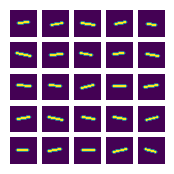

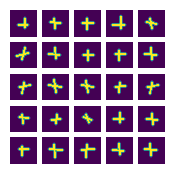

In [4]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #1296

X_text: "6+48 " = y_text: "54 "


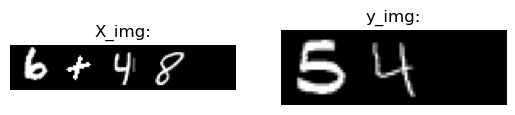

Query #3967

X_text: "19-83" = y_text: "-64"


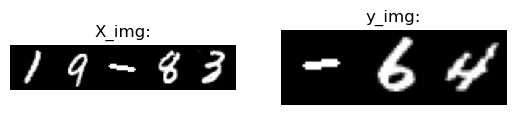

Query #6473

X_text: "32-36" = y_text: "-4 "


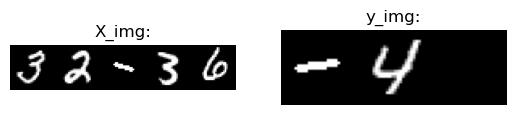

Query #729

X_text: "3-64 " = y_text: "-61"


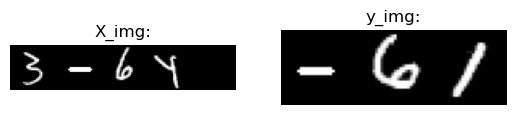

Query #7767

X_text: "38-83" = y_text: "-45"


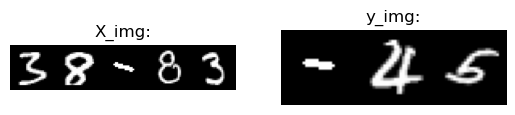

Query #1758

X_text: "8+79 " = y_text: "87 "


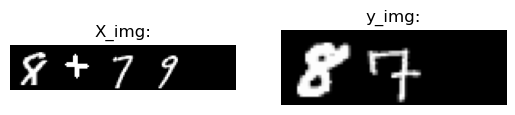

Query #5120

X_text: "25+60" = y_text: "85 "


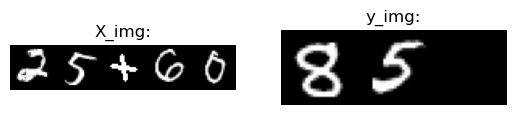

Query #4720

X_text: "23+60" = y_text: "83 "


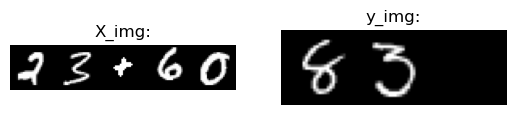

Query #7206

X_text: "36+3 " = y_text: "39 "


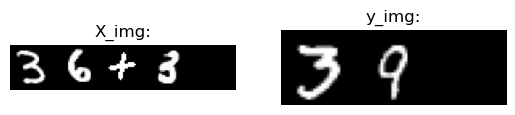

Query #8843

X_text: "44-21" = y_text: "23 "


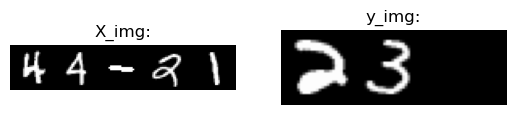

In [7]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [8]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
(## Your first task is to fit the text2text model using X_text and y_text)







---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,  y_test = train_test_split(X_img, y_text_onehot, test_size=0.10, random_state=42) 
X_train, X_valid,y_train,  y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42) 


In [7]:
print("Is GPU being used: ", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU being used:  True


I0000 00:00:1732572351.441929  849969 gpu_device.cc:2022] Created device /device:GPU:0 with 6018 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_img2text_model1():
    img2text = Sequential()

    # ConvLSTM2D Layer 1
    img2text.add(ConvLSTM2D(filters=128,
                            kernel_size=(3, 3),
                            padding="same",
                            return_sequences=True,
                            activation="relu",
                            input_shape=(5, 28, 28, 1),
                            kernel_regularizer=l2(0.01)),stateful=False,  # Ensure no state carryover
        recurrent_dropout=0.0)
    img2text.add(TimeDistributed(GlobalMaxPooling2D()))
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))

    # ConvLSTM2D Layer 2
 

    # GlobalMaxPooling2D applied to each timestep
    

    # Dense layer to reduce dimensionality
    img2text.add(Dense(256, activation='relu'))
    
    img2text.add(LSTM(256))

    # Create fixed-length sequence for the decoder
    #img2text.add(GlobalAveragePooling1D())  # Reduces time dimension
    img2text.add(RepeatVector(max_answer_length))  # Repeats vector max_answer_length times

    # Decoder: LSTM Layers
    img2text.add(LSTM(256, return_sequences=True, recurrent_dropout=0.1))
   
  

    # Output Layer: Generate characters at each timestep
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax', kernel_regularizer=l2(0.01))))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    img2text.summary()
    return img2text


def build_img2text_model():
    model = Sequential()

    # Simplified ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same",
                          activation="relu",return_sequences = True, 
                         input_shape= (5, 28, 28, 1), kernel_regularizer=l2(0.001), dilation_rate = 1))
   
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Increased dropout
 
    # Spatial Feature Reduction
    #model.add(GlobalMaxPooling2D())
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same",
                          activation="relu",return_sequences = True, 
                          kernel_regularizer=l2(0.001)))
   
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Increased dropout
 
    # Spatial Feature Reduction
    model.add(TimeDistributed(GlobalMaxPooling2D()))
    # Dense Layer to Reduce Dimensions
    #model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(128, activation='relu', kernel_regularizer=l2(0.001))))
    model.add(LSTM(256))
    
    model.add(RepeatVector(max_answer_length))  # Repeats vector max_answer_length times

    # Temporal Sequence Modeling with LSTM
    model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

    # Output Layer for Character Prediction
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax', kernel_regularizer=l2(0.001))))

    # Compile Model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

model = build_img2text_model()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 5, 28, 28, 16)  │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5, 28, 28, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 28, 28, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 5, 28, 28, 32)  │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 28, 28, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 5, 128)         │         4,224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,589 (3.79 MB)

 Trainable params: 992,493 (3.79 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:

import keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


model.save(f'submission1_image_to_text.keras')

import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/100


E0000 00:00:1732412478.946986 3720146 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/StatefulPartitionedCall/gradient_tape/sequential_9_1/conv_lstm2d_12_1/while/sequential_9_1/conv_lstm2d_12_1/while_grad/body/_613/input/_1284' -> 'StatefulPartitionedCall/gradient_tape/sequential_9_1/conv_lstm2d_12_1/while/sequential_9_1/conv_lstm2d_12_1/while_grad/body/_613/gradient_tape/sequential_9_1/conv_lstm2d_12_1/while/gradients/AddN', 'Func/StatefulPartitionedCall/gradient_tape/sequential_9_1/conv_lstm2d_11_1/while/sequential_9_1/conv_lstm2d_11_1/while_grad/body/_763/input/_1373' -> 'StatefulPartitionedCall/gradient_tape/sequential_9_1/conv_lstm2d_11_1/while/sequential_9_1/conv_lstm2d_11_1/while_grad/body/_763/gradient_tape/sequential_9_1/conv_lstm2d_11_1/while/gradients/AddN', 'StatefulPartitionedCall/sequential_9_1/conv_lstm2d_12_1/while/body/_207/sequential_9_1/conv_lstm2d_12_1/while/conv_lstm_cell_1

2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.3341 - loss: 2.1167 - val_accuracy: 0.3970 - val_loss: 1.8774 - learning_rate: 0.0010
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.3976 - loss: 1.8827 - val_accuracy: 0.3950 - val_loss: 1.8692 - learning_rate: 0.0010
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.3985 - loss: 1.8681 - val_accuracy: 0.3861 - val_loss: 1.9396 - learning_rate: 0.0010
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.3962 - loss: 1.8529 - val_accuracy: 0.4067 - val_loss: 1.8142 - learning_rate: 0.0010
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4068 - loss: 1.8082 - val_accuracy: 0.4035 - val_loss: 1.8054 - learning_rate: 0.0010
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4104 - loss: 1.7745 - val_accuracy: 0.4143 - val_loss: 1.7564 - learning_rate: 0.0010
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

[0 1 2 3 4 5 6 7 8 9]
1


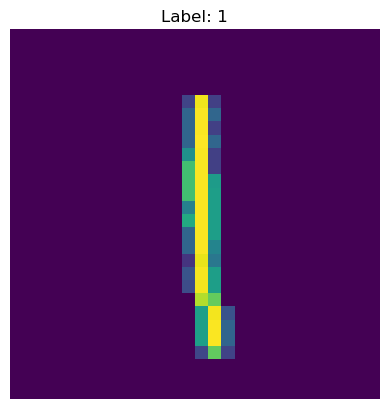

(54000,)
(54000, 28, 28, 1)
1
X_train shape: (54000, 28, 28, 1)
54000 train samples
1
Input shape is  (28, 28, 1)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,890 (1.64 MB)

 Trainable params: 430,890 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8745 - loss: 2.3215 - val_accuracy: 0.9808 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 2/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9720 - loss: 0.3517 - val_accuracy: 0.9850 - val_loss: 0.1801 - learning_rate: 1.0000e-04
Epoch 3/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9776 - loss: 0.1845 - val_accuracy: 0.9820 - val_loss: 0.1453 - learning_rate: 1.0000e-04
Epoch 4/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9809 - loss: 0.1436 - val_accuracy: 0.9875 - val_loss: 0.1196 - learning_rate: 1.0000e-04
Epoch 5/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9827 - loss: 0.1259 - val_accuracy: 0.9882 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 6/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9842 - loss: 0.1123 - val_accuracy: 0.9878 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 7/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 12s 

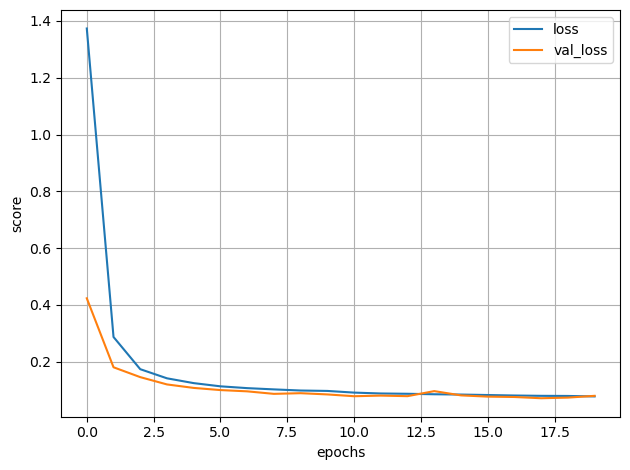

score for Adam, #params:430890 [0.05861639976501465, 0.9926000237464905]


In [126]:
#MNIST CLASSIFICATION

from keras import layers
import keras_tuner
import keras
from tensorflow.keras.datasets import fashion_mnist, cifar10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import pandas as pd
import pickle
import json

class Dataset_prep():
    def __init__(self, X_train,X_valid, y_train, y_valid,x_test,y_test, input_shape):
        self.input_shape = input_shape
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.x_test = x_test
        self.y_test = y_test

def load_data(num_classes):
    
    img_rows, img_cols = 28, 28
    #(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = x_train
    y = y_train
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=42)
    
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
        
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    
    plt.imshow(X_train[0])
    plt.title(f"Label: {y_train[0]}")
    unique_classes = np.unique(y_train)
    print(unique_classes)
    print(y_train[0])
    plt.axis('off')  # Remove the axes for better visualization
    plt.show()


   
    print(y_train.shape)
    print(X_train.shape)
    print(y_train[0])



    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    x_test = x_test.astype('float32')
    X_train /= 255
    X_valid /= 255
    x_test /= 255
    
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    #print(X_valid.shape[0], 'valid samples')
    print(y_train[0])
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    input_shape = X_train.shape[1:]
    print("Input shape is ",input_shape)
  
    
    dataset_p = Dataset_prep(X_train,X_valid, y_train, y_valid,x_test,y_test, input_shape)
    
    return dataset_p

num_classes = 10
dataset_p = load_data(num_classes)


from tensorflow import keras as k
def build_model3( input_shape, kernel_initializer, activation):
    
    #regularizer
    #l1_strength = hp.Float('l1_strength', min_value = 1e-5, max_value = 1e-3, sampling='log')
    kernel_regularizer = k.regularizers.L2(0.01) 
    #kernel_initializer = hp.Choice("kernel_initializer", values = ["he_normal","random_normal",'glorot_uniform'])
    
    #activation = hp.Choice("activation",values= ["relu","tanh"])
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation =activation, input_shape = input_shape, kernel_initializer = kernel_initializer, padding = 'same'))
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activation, kernel_initializer = kernel_initializer, padding='same'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    
  
    model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer = kernel_initializer,kernel_regularizer = kernel_regularizer))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer = kernel_initializer))
    
    #model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer = kernel_initializer))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.1))
    
  
    model.add(Flatten())
    model.add(Dense(128, activation=activation,kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='softmax'))

    #learning_rate = hp.Float("learning_rate", min_value=0.001, max_value=0.1, sampling="log")
    #momentum = hp.Float("momentum", min_value=0.09, max_value=0.9, step=0.1)
    
    # Create the optimizer with the tunable parameters

    #optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001, weight_decay = 1e-4
        ),
        #optimizer = optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model



input_shape = dataset_p.input_shape
kernel_initializer = 'he_normal'
activation = 'relu'

model3 = build_model3(input_shape, kernel_initializer, activation)

# history3 = model3.fit(dataset_p.X_train, dataset_p.y_train,
#           batch_size=64,
#           epochs=30)
          
          #validation_data=(dataset_p.X_valid, dataset_p.y_valid))
# plt.plot(history3.history['loss'], label=f'loss with Adam, #params:{model3.count_params()}')


import keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"mnist_classification_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model3.fit(
    dataset_p.X_train,
    dataset_p.y_train,
    validation_data=(dataset_p.X_valid, dataset_p.y_valid),
    batch_size=8,
    epochs=20,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)




import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('mnist_classification.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()



# print(f"score for Adam, #params:{model1.count_params()}", score1)
# print(f"score for SGD, #params:{model2.count_params()}", score2)
print(f"score for Adam, #params:{model3.count_params()}", score3)



# plt.xlabel('epochs')
# plt.ylabel('score')
# plt.legend(loc="best")

      
# Your code


In [128]:
model3.save(f'mnist_classification_final.keras')
  

[0.06676630675792694, 0.9912999868392944]
(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[0]


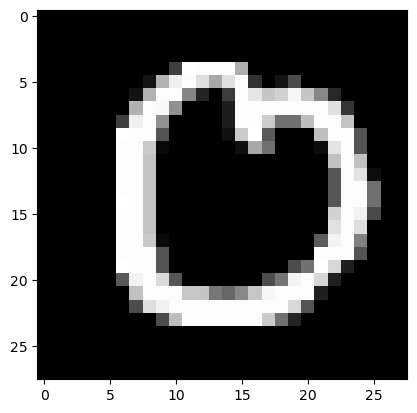

In [140]:
score3 = model3.evaluate(dataset_p.x_test, dataset_p.y_test, verbose=0) 


print(score3)
images = tf.unstack(y_img[100], axis=0)
single_image = images[1]  # Shape: (28, 28, 1)
plt.imshow(single_image, cmap='gray')

# to check for blank image 
if np.all(single_image==0):
    print(True)
    
single_image_batch = tf.expand_dims(single_image, axis=0)  # Shape: (1, 28, 28, 1)
print(single_image_batch.shape)

predictions = model3.predict(single_image_batch)

predicted_classes = predictions.argmax(axis =1)
print(predicted_classes)


In [9]:

# TEXT TO IMAGE PREPARATION
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,  y_test = train_test_split(X_text_onehot, y_img, test_size=0.10, random_state=42) 
X_train, X_valid,y_train,  y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42) 


In [10]:
y_test.shape

(2000, 3, 28, 28)

In [147]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_text2img_model():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))

    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    
    text2img.add(LSTM(256, return_sequences=True))
    
    #text2img.add(TimeDistributed(Dense(len(unique_characters), activation='softmax', kernel_regularizer=l2(0.001))))
    text2img.add(Dropout(0.1))
    text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))

    text2img.add(Reshape((3, 28, 28,1)))

    default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=1, **default_args)))
    #text2img.add(TimeDistributed(Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')))
    
    #text2img.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'))

    #text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img

model = build_text2img_model()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_36 (RepeatVector) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_97             │ (None, 3, 784)         │       201,488 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_36 (Reshape)            │ (None, 3, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_98             │ (None, 3, 28, 28, 1)   │            10 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,290 (3.83 MB)

 Trainable params: 1,003,290 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
y_img.shape

(20000, 3, 28, 28)

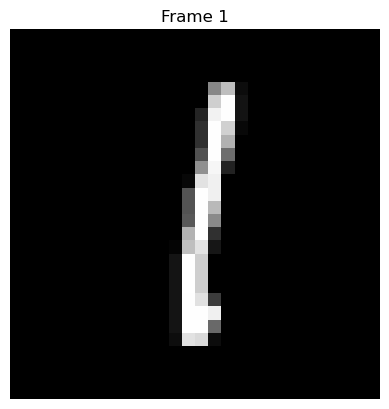

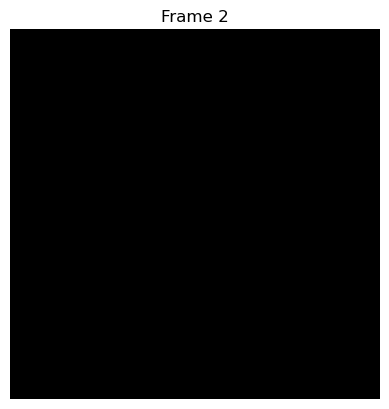

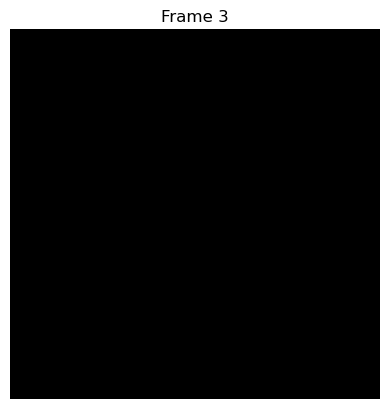

In [149]:
for i, frame in enumerate(y_img[200]):
        

    plt.imshow(frame, cmap='gray')  # Display the frame in grayscale
    plt.title(f"Frame {i + 1}")
    plt.axis("off")
    plt.show()

In [150]:
# Your code

import keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_to_image_best_previous.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=50,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


model.save(f'submission1_text_to_image_previous.keras')


Epoch 1/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8663 - loss: 0.0831 - val_accuracy: 0.8665 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 2/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8658 - loss: 0.0574 - val_accuracy: 0.8665 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 3/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8660 - loss: 0.0570 - val_accuracy: 0.8665 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 4/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8658 - loss: 0.0557 - val_accuracy: 0.8656 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 5/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8654 - loss: 0.0544 - val_accuracy: 0.8646 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 6/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8644 - loss: 0.0512 - val_accuracy: 0.8624 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 7/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8640

KeyboardInterrupt: 

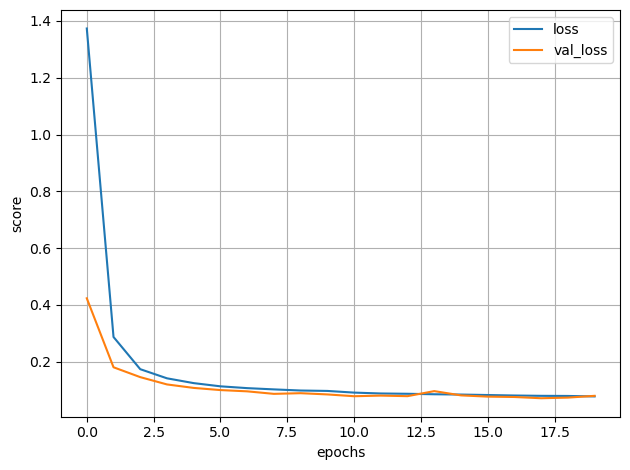

In [145]:

import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history_previous.csv')
plt.plot(data_history['loss'], label='loss')
plt.plot(data_history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()




In [152]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_text2img_model():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))

    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    
    text2img.add(LSTM(256, return_sequences=True))
    
    #text2img.add(TimeDistributed(Dense(len(unique_characters), activation='softmax', kernel_regularizer=l2(0.001))))
    text2img.add(Dropout(0.1))
    text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))

    text2img.add(Reshape((3, 28, 28,1)))

    default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=1, **default_args)))
    #text2img.add(TimeDistributed(Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')))
    
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid')))

    #text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img

model = build_text2img_model()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_74 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_37 (RepeatVector) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_99             │ (None, 3, 784)         │       201,488 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_37 (Reshape)            │ (None, 3, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_100            │ (None, 3, 28, 28, 1)   │            10 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_101            │ (None, 3, 28, 28, 1)   │            10 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,300 (3.83 MB)

 Trainable params: 1,003,300 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8664 - loss: 0.1918 - val_accuracy: 0.8665 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 2/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8656 - loss: 0.0790 - val_accuracy: 0.8665 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 3/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8661 - loss: 0.0720 - val_accuracy: 0.8665 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 4/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8661 - loss: 0.0715 - val_accuracy: 0.8665 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 5/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8658 - loss: 0.0717 - val_accuracy: 0.8665 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 6/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8658 - loss: 0.0717 - val_accuracy: 0.8665 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 7/50
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.865

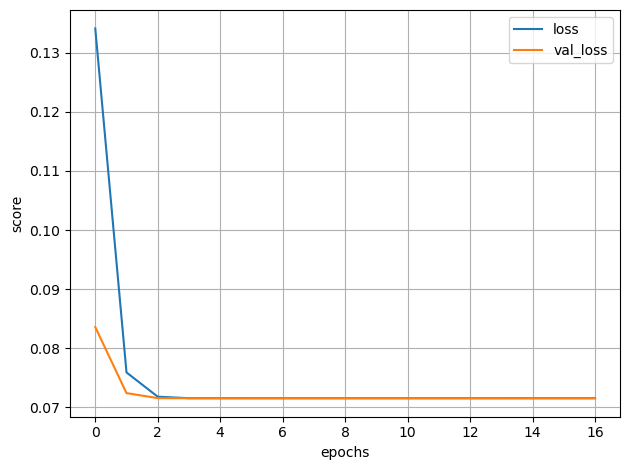

In [153]:
# Your code

import keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_to_image_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=50,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


model.save(f'submission1_image_to_text.keras')

import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()




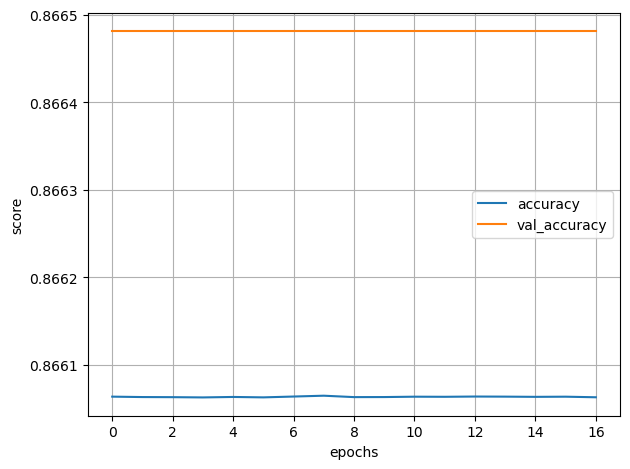

In [154]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

